# Bike Ride Time Prediction Report

In [1]:
%load_ext lab_black

In [2]:
# Imports
import datetime
import logging

import ipytest
import matplotlib.pyplot as plt
import numpy
import numpy as np
import pandas as pd
import pandera as pa
import plotly.offline as py
import pytest
from IPython.core.display import HTML, display
from IPython.display import Markdown as md
from matplotlib.pyplot import figure
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
# Logging
class OutputWidgetHandler(logging.Handler):
    """ Custom logging handler sending logs to an output widget """

    def __init__(self, *args, **kwargs):
        super(OutputWidgetHandler, self).__init__(*args, **kwargs)

    def emit(self, record):
        """ Overload of logging.Handler method """
        formatted_record = self.format(record)
        if record.levelname == "INFO":
            log_icon = "ℹ️"
            color = "#87cefa"
        elif record.levelname == "WARNING":
            log_icon = "⚠️"
            color = "#ffffb3"
        elif record.levelname == "ERROR":
            log_icon = "❗"
            color = "#fa8072"
        display(
            HTML(
                f'<p style="padding-left: 5px; background-color: {color}">{log_icon} {formatted_record}</p>'
            )
        )
        if record.levelname == "ERROR":
            raise SystemExit("Stop right there!")

    def show_logs(self):
        """ Show the logs """
        display(self.out)

    def clear_logs(self):
        """ Clear the current logs """
        self.out.clear_output()


logger = logging.getLogger(__name__)
handler = OutputWidgetHandler()
handler.setFormatter(logging.Formatter("%(message)s"))
logger.addHandler(handler)
logger.setLevel(logging.INFO)

In [4]:
# Initialise schema
schema = pa.DataFrameSchema(
    {
        "start_date": pa.Column(pa.PandasDtype.DateTime),
        "station_code": pa.Column(float),
        "duration_sec": pa.Column(int),
        "is_member": pa.Column(int, pa.Check.isin([0, 1])),
        "predicted_duration_sec": pa.Column(float, pa.Check.ge(0)),
    }
)

In [5]:
# Test Schema
ipytest.autoconfig()

In [6]:
%%run_pytest[clean] -qq

logger.info("Running tests")

DT = datetime.datetime(2020, 5, 17)

columns = ['start_date', 'station_code', 'is_member', 'duration_sec', 'predicted_duration_sec']

def test_validation_nulls():
    with pytest.raises(pa.errors.SchemaError) as e_info:
        df = pd.DataFrame([
            [DT, 123.0, 1, 567, None]
        ],
        columns=columns)
        schema(df)
        
    assert "contains null values" in str(e_info.value)
    
def test_negative_prediction():
    with pytest.raises(pa.errors.SchemaError) as e_info:
        df = pd.DataFrame([
            [DT, 123.0, 1, 567, -1.0]
        ],
        columns=columns)
        schema(df)
        
    assert "greater_than_or_equal_to" in str(e_info.value)
    
def test_non_date_time():
    with pytest.raises(pa.errors.SchemaError) as e_info:
        df = pd.DataFrame([
            ["2019-10-25", 123.0, 1, 567, 567.0]
        ],
        columns=columns)
        schema(df)
    
def test_member_is_in_one_or_zero():
    with pytest.raises(pa.errors.SchemaError) as e_info:
        df = pd.DataFrame([
            [DT, 123.0, 2, 567, 567.0]
        ],
        columns=columns)
        schema(df)
        
    assert "isin" in str(e_info.value)

def test_columns_present():
    with pytest.raises(pa.errors.SchemaError) as e_info:
        df = pd.DataFrame([
            [DT, 123.0, 1, 567.0]
        ],
        columns=['start_date', 'station_code', 'is_member', 'duration_sec'])
        schema(df)
        
    assert "column 'predicted_duration_sec' not in dataframe" in str(e_info.value)

.....                                                                                                                                                                                                 [100%]


In [7]:
def check_tests():
    """Checks if last run pytest tests succeeded or failed"""

    if ipytest.exit_code != ipytest.exit_code.OK:
        logger.error("Tests failed")
    else:
        logger.info("Tests passed")

In [8]:
check_tests()

In [9]:
# Metric Functions
def percentage_within_sla(df, sla_secs):
    """Determines the proportion of residuals that fall below a given SLA"""
    return (df["residual"].abs() <= sla_secs).sum() / len(df)

In [10]:
%%run_pytest[clean]

def test_percentage_within_sla():
    df = pd.DataFrame([
        [1], [2], [3], [-1], [-10]
    ], columns=["residual"])
    assert percentage_within_sla(df, 5) == 0.8

.                                                                                                                                                                                                     [100%]
1 passed in 0.01s


In [11]:
check_tests()

# Ingestion

In [12]:
# Read data
logger.info("Ingesting Data")
df = pd.read_parquet("bixi_predictions.parquet")
df = df.reset_index()

In [13]:
num_rows = len(df)
num_members = (df["is_member"] == 1).sum()
num_not_members = (df["is_member"] == 0).sum()

In [14]:
md(
    f"""
✔️ Data ingested
- Number rows: {num_rows}
- Members: {num_members}
- Non-Members {num_not_members}
"""
)


✔️ Data ingested
- Number rows: 245209
- Members: 146875
- Non-Members 98334


In [15]:
try:
    logger.info("Validating schema")
    validated_df = schema(df)
except pa.errors.SchemaError as e:
    logger.error("Validation error found in schema")
    raise e
except:
    pass
md("✔️ Schema validated without errors")

✔️ Schema validated without errors

## Accuracy Metrics

In [16]:
df["residual"] = df["duration_sec"] - df["predicted_duration_sec"]
df["residual_mins"] = (df["residual"]) / 60

In [17]:
y_actual = df["duration_sec"]
y_predicted = df["predicted_duration_sec"]

THRESHOLD_RMSE = 1000
THRESHOLD_R2 = 0.50

rmse = mean_squared_error(y_actual, y_predicted, squared=False)
r2 = r2_score(y_actual, y_predicted)

In [18]:
logger.info("Validating Metrics")

In [19]:
logger.info(f"Root Mean Squared Error (RMSE): {rmse}")
if rmse < THRESHOLD_RMSE:
    logger.warning(f"RMSE is below acceptable threshold of {THRESHOLD_RMSE}")

logger.info(f"R-Squared (R^2): {r2}")
if r2 < THRESHOLD_R2:
    logger.warning(f"R^2 is below acceptable threshold of {THRESHOLD_R2}")

In [20]:
md(
    f"""
Accuracy metrics are as follows:
- Root Mean Squared Error (RMSE): {rmse:.2f}
- R-Squared Score (R^2): {r2:.2%}
"""
)


Accuracy metrics are as follows:
- Root Mean Squared Error (RMSE): 1026.64
- R-Squared Score (R^2): 33.10%


## Service Level Agreement

In [21]:
THRESHOLD_SLA_MINS = 10
THRESHOLD_SLA_SECONDS = THRESHOLD_SLA_MINS * 60
THRESHOLD_SLA_PERCENTAGE = 0.50

percentage_within_threshold = percentage_within_sla(df, THRESHOLD_SLA_SECONDS)

logger.info(
    f"{percentage_within_threshold:.2%} of predictions are within {THRESHOLD_SLA_MINS} minute SLA"
)
if percentage_within_threshold < THRESHOLD_SLA_PERCENTAGE:
    logger.warning(
        f"Less than {THRESHOLD_SLA_PERCENTAGE:.2%} of predictions are within the +- {THRESHOLD_SLA_MINS} minute SLA"
    )

In [22]:
md(
    f"""
We are aiming to have at least half of our predictions within 10 minutes of the actual time. Given this we have the following:
- Percentage of predictions within {THRESHOLD_SLA_MINS}min SLA: {percentage_within_threshold:.2%}
"""
)


We are aiming to have at least half of our predictions within 10 minutes of the actual time. Given this we have the following:
- Percentage of predictions within 10min SLA: 59.81%


## Plots

### Scatter Residual Plot
The following plots predicted values against predicted. Points closer to the black line are considered a more accurate prediction

Text(0.5, 1.0, 'Predicted duration against actual duration')

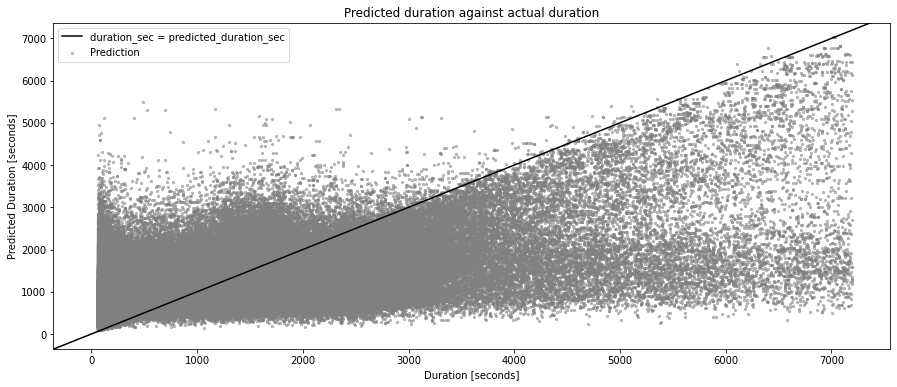

In [23]:
# Predicted against actual duration
fig, ax = plt.subplots()
fig.set_figheight(6)
fig.set_figwidth(15)
ax.axline([0, 0], [1, 1], color="black", label="duration_sec = predicted_duration_sec")
ax.scatter(
    df["duration_sec"],
    df["predicted_duration_sec"],
    alpha=0.5,
    s=5,
    c="grey",
    label="Prediction",
)
plt.legend(loc="upper left")
plt.xlabel("Duration [seconds]")
plt.ylabel("Predicted Duration [seconds]")
plt.title("Predicted duration against actual duration")

### Histogram Residual Plot
This graph will highlight the proportion of predicted values sit within a particular difference from the true value

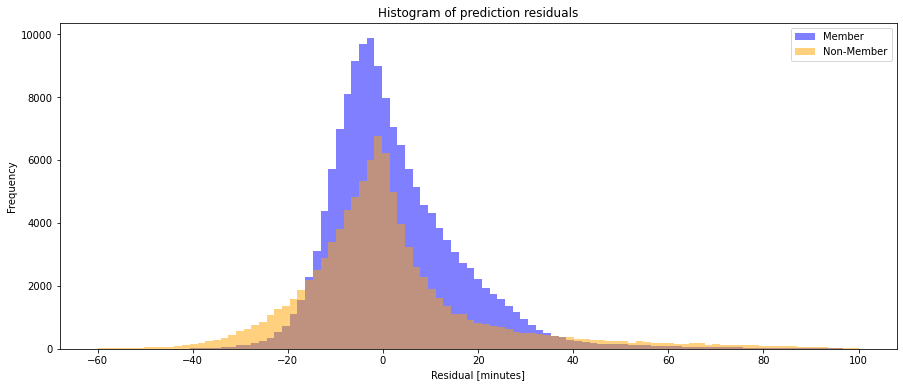

In [24]:
figure(figsize=(15, 6))
fig = plt.axes
bins = np.linspace(-60, 100, 100)

member = df[df["is_member"] == 1]
not_member = df[df["is_member"] == 0]
member_residuals = member["residual_mins"].to_list()
not_member_residuals = not_member["residual_mins"].to_list()

plt.hist(member_residuals, bins, alpha=0.5, label="Member", color="blue")
plt.hist(not_member_residuals, bins, alpha=0.5, label="Non-Member", color="orange")
plt.legend(loc="upper right")
plt.xlabel("Residual [minutes]")
plt.ylabel("Frequency")
plt.title("Histogram of prediction residuals")
plt.show()